# ZTF24aahgqwk in NGC 3443

## Light Curve Notebook

This notebook begins with the 36 stacked images produced by our [Calibration Notebook](https://brianhill.github.io/supernova-observation/analyses/ZTF24aahgqwk/ZTF24aahgqwk-calibration.pdf), and produces a light curve, consisting of 18 Sloan r' and 18 Sloan g' data points.

See [a least squares notebook](https://brianhill.github.io/supernova-observation/analyses/ZTF24aahgqwk/related_analyses/least_squares.pdf) for
background for the method used below.

In [1]:
import os
import numpy as np
from scipy.optimize import least_squares
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import astroalign as aa
import matplotlib.pyplot as plt
%matplotlib inline
from math import log10, floor

# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.
# THIS COMMENT IS 72 CHARACTERS WITHOUT COUNTING THE NEWLINE AT THE END.

# This notebook needs to be able to find the stacked images.

home_directory = os.path.expanduser('~')
supernova_project_directory = os.path.join(home_directory, 'Projects', 'supernova-observation')
stacked_directory = os.path.join(supernova_project_directory, 'analyses', 'ZTF24aahgqwk', 'stacked')

# The 36 images are in the stacked directory. There were 18 observation sessions with 2 filters each.

# filters

filters = ['r', 'g']
filter_full_names = ["Sloan r'", "Sloan g'"]

# observation dates (UTC)

observation_dates = [
    '2024-03-20',
    '2024-03-21',
    '2024-03-23',
    '2024-03-27',
    '2024-04-02',
    '2024-04-03',
    '2024-04-04',
    '2024-04-06',
    '2024-04-10',
    '2024-04-11',
    '2024-04-13',
    '2024-04-17',
    '2024-04-21',
    '2024-04-22',
    '2024-04-23',
    '2024-04-29',
    '2024-04-30',
    '2024-05-02'
]

# We will need to specify rectangles surrounding the target and the reference stars.

# use named tuples to improve readability

from collections import namedtuple

Point = namedtuple('Point', 'x y')
Extent = namedtuple('Extent', 'width height')
Rectangle = namedtuple('Rectangle', 'center extent')

# Various utilities

def file_for_date_and_filter(date, filter):
    return os.path.join(stacked_directory, date + '-' + filter + '_stacked.fit')

def stacked_image_for_date_and_filter(date, filter):
    file = file_for_date_and_filter(date, filter)
    return CCDData.read(file, unit=u.adu)

# Log stretch utility

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        if pixel_value <= 1.0:
            return 0
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn


## Specify the Regions of Interest for the Target and Reference Stars

In [2]:
supernova_center = Point(708, 443)
# guarantee that the full widths and heights are odd to make the loops easier
extent_half_width = 7
extent_width = 2 * extent_half_width + 1
extent_height = extent_width
extent = Extent(extent_width, extent_height)
supernova_roi = Rectangle(supernova_center, extent)

## Display a Representative Image


Set OBSGEO-Y to -4483194.922 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851220.317 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


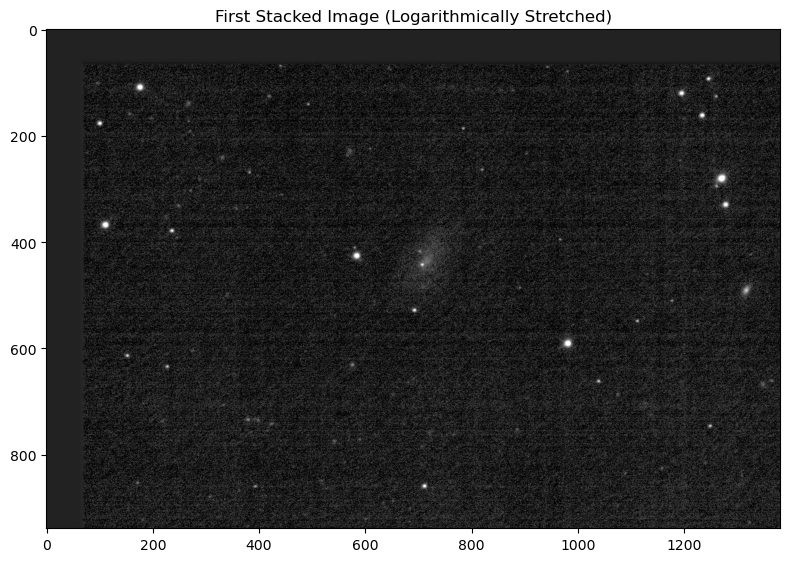

In [3]:
first_image = stacked_image_for_date_and_filter('2024-03-20', 'r')

# Log stretch

stretch_function = log_stretch_transform(26, 50)
stretch_transform = np.vectorize(stretch_function)

stretched_image = stretch_transform(first_image.data)

# Display the image

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(stretched_image, cmap='gray')
axes.set_title("First Stacked Image (Logarithmically Stretched)")

plt.tight_layout()
plt.show()


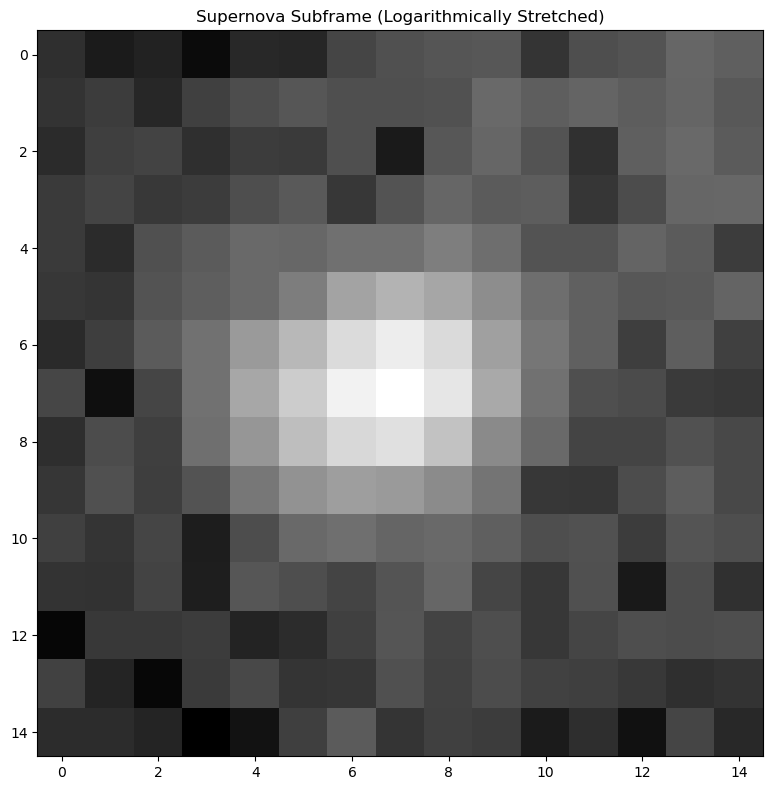

In [4]:
supernova_center = Point(708, 443)
# guarantee that the full widths and heights are odd to make the loops easier
extent_half = 7
extent_width = 2 * extent_half + 1
extent_height = extent_width
extent = Extent(extent_width, extent_height)
supernova_roi = Rectangle(supernova_center, extent)

supernova_subframe = stretched_image[
    supernova_center.y-extent_half:supernova_center.y+extent_half+1,
    supernova_center.x-extent_half:supernova_center.x+extent_half+1
]

# Display the representative subtracted dark

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(supernova_subframe, cmap='gray')
axes.set_title("Supernova Subframe (Logarithmically Stretched)")

plt.tight_layout()
plt.show()
from collections import namedtuple
Point = namedtuple('Point', 'x y')
pt1 = Point(1.0, 5.0)
pt2 = Point(2.5, 1.5)

from math import sqrt
line_length = sqrt((pt1.x-pt2.x)**2 + (pt1.y-pt2.y)**2)


In [5]:

def make_residuals_function(image_data, target_roi):
    def residuals_function(parameter_vector):
        background = parameter_vector[0]
        return np.array([image_data[target_roi.center.y, target_roi.center.x] - background])
    
    return residuals_function

initial_guess_for_background = 0.0

initial_parameter_vector = [initial_guess_for_background]

residuals_function = make_residuals_function(first_image, supernova_roi)

result = least_squares(residuals_function, np.array(initial_parameter_vector))

print(result.x)

[74.40825579]
